In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-0.4.0-SNAPSHOT-jar-with-dependencies.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '../../','data', 'charity.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/charity.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [6]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
for col in dframe.columns:
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
    node_list.add(nodi)

In [7]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(dframe.index),dframe.columns.size)

In [8]:
for col in range(0,dframe.columns.size):
    for row in dframe.index:
        value = javabridge.make_instance("java/lang/Double", "(D)V", dframe.iloc[row,col])
        dataBox.set(row,col,value)

In [9]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [10]:
tetradData = javabridge.JClassWrapper("edu.cmu.tetrad.data.CovarianceMatrixOnTheFly")(boxData)

In [11]:
testType = 'TETRAD_WISHART'
fofcAlgorithm = 'GAP'
alpha = .01

In [12]:
testType = javabridge.get_static_field('edu/cmu/tetrad/search/TestType',testType,'Ledu/cmu/tetrad/search/TestType;')

In [13]:
fofcAlgorithm = javabridge.get_static_field('edu/cmu/tetrad/search/FindOneFactorClusters$Algorithm', 
                                            fofcAlgorithm, 
                                            'Ledu/cmu/tetrad/search/FindOneFactorClusters$Algorithm;')

In [14]:
fofc = javabridge.JClassWrapper('edu.cmu.tetrad.search.FindOneFactorClusters')(tetradData, testType, fofcAlgorithm, alpha)

In [15]:
tetradGraph = fofc.search()

In [16]:
tetradGraph.toString()

'Graph Nodes:\nTangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact,_L1\n\nGraph Edges:\n1. _L1 --> AmountDonated\n2. _L1 --> Imaginability\n3. _L1 --> Impact\n4. _L1 --> Sympathy\n5. _L1 --> TangibilityCondition\n'

In [17]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [TangibilityCondition, AmountDonated, Sympathy, Imaginability, Impact, _L1]

In [18]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [_L1 --> AmountDonated, _L1 --> TangibilityCondition, _L1 --> Imaginability, _L1 --> Sympathy, _L1 --> Impact]

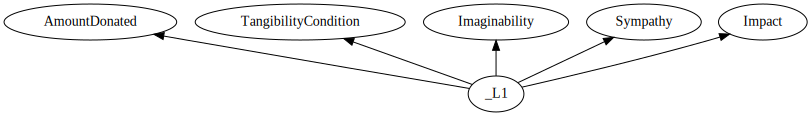

In [19]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [20]:
javabridge.detach()
javabridge.kill_vm()